In [1]:
import json
import torch
import numpy as np
import pandas as pd
import geopandas as gpd
from src import model_utils
from datetime import datetime
import matplotlib.pyplot as plt
from src.learning.miou import IoU
from src.dataset import compute_norm_vals
from src.utils import cmap, cmap_2, class_names, class_names_2

In [2]:
sample = 55867
data = torch.from_numpy(np.load(f"./JAXA/DATA_S2/S2_{sample}.npy").astype(np.float32))
target = np.load(f"./JAXA/ANNOTATIONS/TARGET_{sample}.npy")
target = torch.from_numpy(target.astype(int))
target = torch.where((target == 4) | (target == 5) | (target == 6) | (target == 7) | (target == 8) | (target == 9) | (target == 10) | (target == 11) | (target == 12),  0, target)

# target = torch.where(target == 12, 8, target)
# target = torch.where(target == 3, 1, 0)

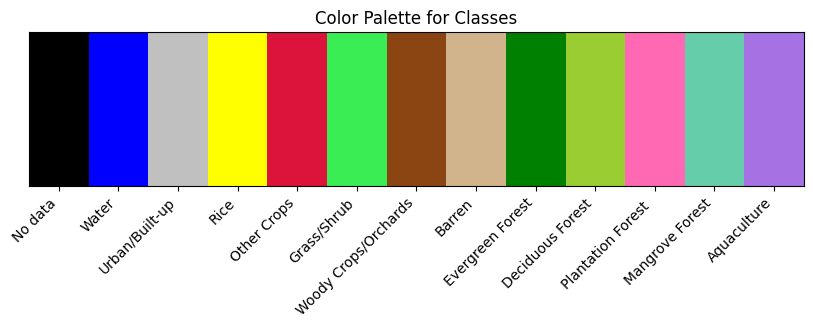

In [10]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.imshow([cmap], aspect='auto')
ax.set_xticks(range(len(cmap)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticks([])

plt.title("Color Palette for Classes")
plt.show()

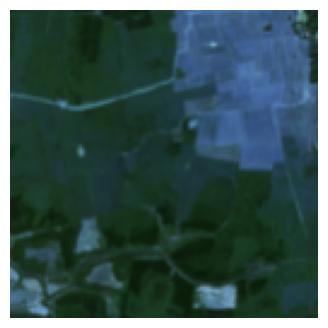

In [11]:
r = data[0][0].numpy()
g = data[0][1].numpy()
b = data[0][2].numpy()
rgb_image = np.stack([r, g, b], axis=-1)
rgb_image = (rgb_image / 3000) * 255
rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)

plt.figure(figsize=(4, 4))
plt.imshow(rgb_image)
plt.axis('off')  
plt.show()

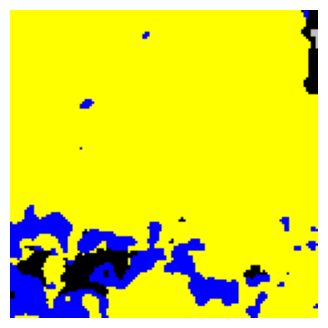

In [12]:
target_image = cmap_2[target]
plt.figure(figsize=(4, 4))
plt.imshow(target_image)
plt.axis('off')
plt.show()

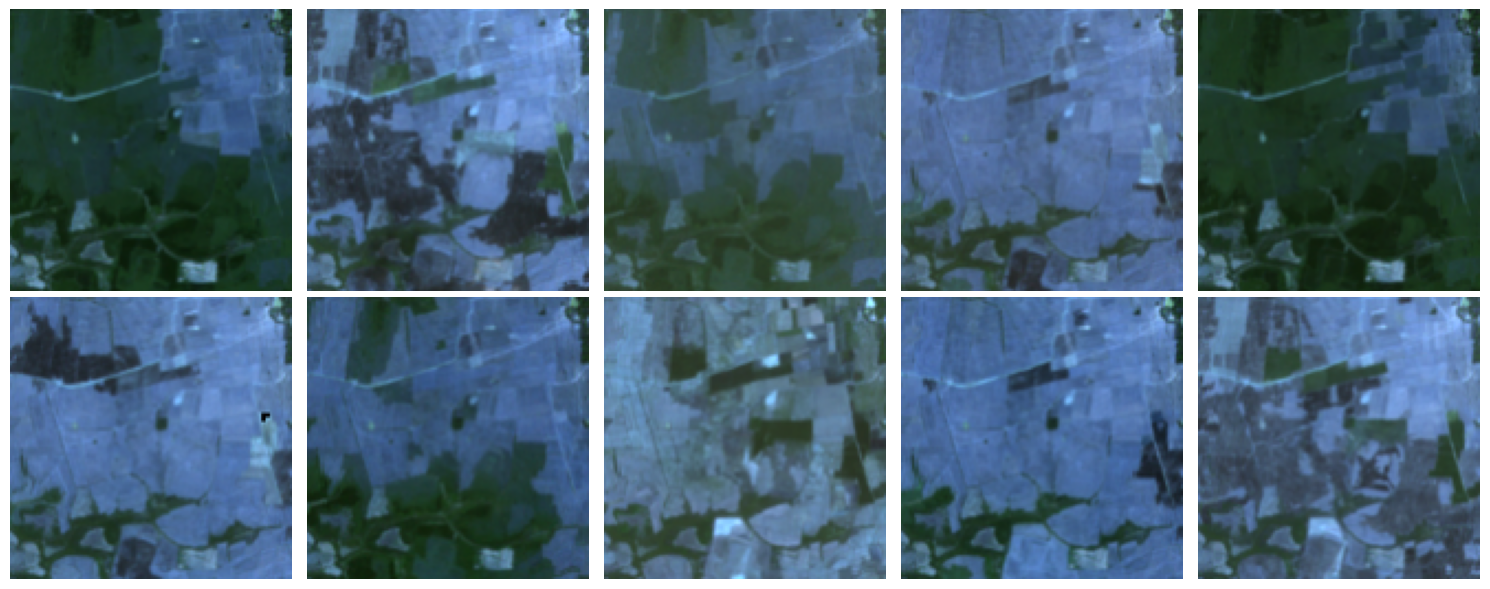

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    
    r = data[i][0].numpy()
    g = data[i][1].numpy()
    b = data[i][2].numpy()
    rgb_image = np.stack([r, g, b], axis=-1)
    rgb_image = (rgb_image / 3000) * 255
    rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)
    axes[row, col].imshow(rgb_image)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [14]:
reference_date = "2018-01-01"
reference_date_d = datetime(*map(int, reference_date.split("-")))

with open("./JAXA/NORM_S2_patch.json", "r") as file:
    normvals = json.loads(file.read())
means = [normvals["Fold_{}".format(f)]["mean"] for f in range(1, 6)]
stds = [normvals["Fold_{}".format(f)]["std"] for f in range(1, 6)]
norm = np.stack(means).mean(axis=0), np.stack(stds).mean(axis=0)
norm = (
    torch.from_numpy(norm[0]).float(),
    torch.from_numpy(norm[1]).float(),
)
data = (data - norm[0][None, :, None, None]) / norm[1][None, :, None, None]

meta_patch = gpd.read_file("./JAXA/metadata.json")
meta_patch.index = meta_patch["ID_PATCH"].astype(int)
meta_patch.sort_index(inplace=True)

date_table = None
date_range = np.array(range(0, 1095))

dates = meta_patch["dates-S2"]
date_table = pd.DataFrame(
    index=meta_patch.index, columns=date_range, dtype=int
)
for pid, date_seq in dates.items():
    if type(date_seq) == str:
        date_seq = json.loads(date_seq)
    d = pd.DataFrame().from_dict(date_seq, orient="index")
    d = d[0].apply(
        lambda x: (
            datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:]))
            - reference_date_d
        ).days
    )
    date_table.loc[pid, d.values] = 1
date_table = date_table.fillna(0)
date_table = {
    index: np.array(list(d.values()))
    for index, d in date_table.to_dict(orient="index").items()
}

FileNotFoundError: [Errno 2] No such file or directory: './JAXA/NORM_S2_patch.json'

In [8]:
dates = torch.from_numpy(date_range[np.where(date_table[sample] == 1)[0]])
x = data.unsqueeze(dim=0), dates.unsqueeze(dim=0)

In [9]:
class config:
    model="utae"
    encoder_widths=[64, 64, 64, 128]
    decoder_widths=[32, 32, 64, 128]
    out_conv=[32, 4]
    str_conv_k=4
    str_conv_s=2
    str_conv_p=1
    agg_mode="att_group"
    encoder_norm="group"
    n_head=16
    d_model=256
    d_k=4
    pad_value=0
    padding_mode="reflect"
    ignore_index=None   
    device="cpu"

In [10]:
device = torch.device(config.device)
model = model_utils.get_model(config)
model = model.to(device)
sd = torch.load("artifacts/4_cl_1/fold_1/model.pth.tar", map_location=device, weights_only=True)
model.load_state_dict(sd["state_dict"])

def recursive_todevice(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    elif isinstance(x, dict):
        return {k: recursive_todevice(v, device) for k, v in x.items()}
    else:
        return [recursive_todevice(c, device) for c in x]
    
x = recursive_todevice(x, device) 

In [11]:
with torch.inference_mode():
    out = model(x[0], batch_positions=x[1])
    # pred = out.squeeze(dim=0).squeeze(dim=0).cpu().numpy()
    pred = out.argmax(dim=1).squeeze(dim=0).cpu().numpy()

In [32]:
# min_max_image = (pred - np.min(pred)) / (np.max(pred) - np.min(pred))
# min_max_image = np.clip(min_max_image * 2 - 1, 0, 1) * 255
# binary_image = np.where(pred >= 0.5, 1, 0)

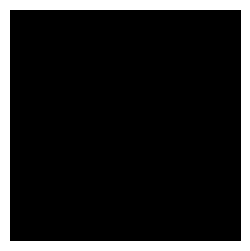

In [12]:
r = data[0][0].numpy()
g = data[0][1].numpy()
b = data[0][2].numpy()
rgb_image = np.stack([r, g, b], axis=-1)
rgb_image = (rgb_image / 3000) * 255
rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)

plt.figure(figsize=(3, 3))
plt.imshow(rgb_image)
plt.axis('off')  
plt.show()

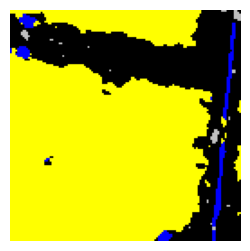

In [13]:
target_image = cmap_2[target]
plt.figure(figsize=(3, 3))
plt.imshow(target_image)
plt.axis('off')
plt.show()

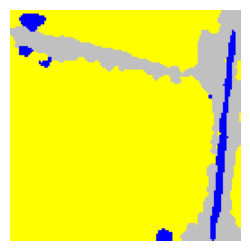

In [14]:
pred_image = cmap_2[pred]
plt.figure(figsize=(3, 3))
plt.imshow(pred_image)
plt.axis('off')  
plt.show()

In [5]:
import json
import os
import shutil

def main():
    # Define paths to your files and directories
    metadata_path = './JAXA/metadata.json'
    target_annotations_folder = './JAXA/ANNOTATIONS'
    target_data_s2_folder = './JAXA/DATA_S2'
    processed_txt = './JAXA/processed.txt'

    metadata_other_path = './JAXA_vm_5/metadata.json'
    annotations_folder = './JAXA_vm_5/ANNOTATIONS'
    data_s2_folder = './JAXA_vm_5/DATA_S2'
    processed_other_txt = './JAXA_vm_5/processed.txt'

    # Ensure target directories exist
    os.makedirs(target_annotations_folder, exist_ok=True)
    os.makedirs(target_data_s2_folder, exist_ok=True)

    # Load metadata.json
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    # Get the highest ID_PATCH and id from metadata.json
    last_id_patch = max(int(feature['properties']['ID_PATCH']) for feature in metadata['features'])
    last_id = max(int(feature['id']) for feature in metadata['features'])

    # Load metadata_other.json
    with open(metadata_other_path, 'r') as f:
        metadata_other = json.load(f)

    # Initialize offsets for new IDs
    id_patch_offset = last_id_patch + 1
    id_offset = last_id + 1

    # Create a mapping from old to new ID_PATCH
    id_patch_map = {}

    # Update IDs in metadata_other.json
    for feature in metadata_other['features']:
        old_id_patch = int(feature['properties']['ID_PATCH'])
        new_id_patch = id_patch_offset
        feature['properties']['ID_PATCH'] = new_id_patch
        id_patch_map[old_id_patch] = new_id_patch
        id_patch_offset += 1

        old_id = int(feature['id'])
        new_id = id_offset
        feature['id'] = str(new_id)
        id_offset += 1

    # Append updated features to metadata.json
    metadata['features'].extend(metadata_other['features'])

    # Save the updated metadata.json
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

    for old_id_patch, new_id_patch in id_patch_map.items():
        # Move and rename TARGET files from annotations_folder to target_annotations_folder
        old_annotation_file = os.path.join(annotations_folder, f'TARGET_{old_id_patch}.npy')
        new_annotation_file = os.path.join(target_annotations_folder, f'TARGET_{new_id_patch}.npy')
        if os.path.exists(old_annotation_file):
            shutil.move(old_annotation_file, new_annotation_file)
        else:
            print(f'Warning: Annotation file {old_annotation_file} does not exist.')

        # Move and rename S2 files from data_s2_folder to target_data_s2_folder
        old_s2_file = os.path.join(data_s2_folder, f'S2_{old_id_patch}.npy')
        new_s2_file = os.path.join(target_data_s2_folder, f'S2_{new_id_patch}.npy')
        if os.path.exists(old_s2_file):
            shutil.move(old_s2_file, new_s2_file)
        else:
            print(f'Warning: Data S2 file {old_s2_file} does not exist.')

    # Concatenate processed_other.txt with processed.txt
    with open(processed_other_txt, 'r') as f_in:
        processed_other_data = f_in.read()

    with open(processed_txt, 'a') as f_out:
        f_out.write('\n')  # Ensure there's a newline before appending
        f_out.write(processed_other_data)

    print('Metadata updated, files moved and renamed, and processed files concatenated successfully.')

if __name__ == '__main__':
    main()

Metadata updated, files moved and renamed, and processed files concatenated successfully.
